In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

DATA_PATH = "battery_logs/Profile-20180726-194341"


In [2]:
import pandas as pd

def load_battery_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "20180726-194341-BatteryDischarge.csv")
    print(csv_path)
    return pd.read_csv(csv_path)

In [3]:
battery = load_battery_data()
battery.head()

battery_logs/Profile-20180726-194341\20180726-194341-BatteryDischarge.csv


Time  Temperature1  Voltage1  RemCap1  FullChgCap1  \
0  2018-07-26 19:43:43.803810          35.1     16378     2306         2306   
1  2018-07-26 19:43:52.483678          35.1     16122     2306         2306   
2  2018-07-26 19:43:57.086138          35.1     16095     2305         2306   
3  2018-07-26 19:44:01.661596          35.1     16092     2304         2306   
4  2018-07-26 19:44:06.261056          35.1     16079     2303         2306   

   AvgCurrent1  StateofCharge1  Cell1Voltage1  Cell2Voltage1  Cell3Voltage1  \
0           91           100.0           4084           4111           4097   
1         -669           100.0           4002           4064           4037   
2         -700           100.0           3992           4059           4031   
3         -689           100.0           3992           4057           4030   
4         -698           100.0           3988           4055           4027   

    ...     RemCap2 FullChgCap2 AvgCurrent2  StateofCharge2  Cell1Voltage2  \
0   ...        2301        2301          93           100.0           4081   
1   ...        2301        2301        -634           100.0           4001   
2   ...        2300        2301        -648           100.0           3996   
3   ...        2299        2301        -642           100.0           3994   
4   ...        2298        2301        -656           100.0           3989   

   Cell2Voltage2  Cell3Voltage2  Cell4Voltage2   packName2  status2  
0           4104           4091           4085  sbs-2-0009     Full  
1           4057           4032           4017  sbs-2-0009     Full  
2           4053           4029           4013  sbs-2-0009     Full  
3           4052           4026           4011  sbs-2-0009     Full  
4           4049           4023           4008  sbs-2-0009     Full  

[5 rows x 25 columns]

In [4]:
battery.info()
# battery.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 25 columns):
Time              2486 non-null object
Temperature1      2486 non-null float64
Voltage1          2486 non-null int64
RemCap1           2486 non-null int64
FullChgCap1       2486 non-null int64
AvgCurrent1       2486 non-null int64
StateofCharge1    2486 non-null float64
Cell1Voltage1     2486 non-null int64
Cell2Voltage1     2486 non-null int64
Cell3Voltage1     2486 non-null int64
Cell4Voltage1     2486 non-null int64
packName1         2486 non-null object
status1           2486 non-null object
Temperature2      2486 non-null float64
Voltage2          2486 non-null int64
RemCap2           2486 non-null int64
FullChgCap2       2486 non-null int64
AvgCurrent2       2486 non-null int64
StateofCharge2    2486 non-null float64
Cell1Voltage2     2486 non-null int64
Cell2Voltage2     2486 non-null int64
Cell3Voltage2     2486 non-null int64
Cell4Voltage2     2486 non-null int64
packName

In [5]:
from datetime import datetime
    
def datetime_to_elapsed(datetime_array):
    datetime_object = []
    delta_array = []
    for i in range(len(battery.Time)):
        datetime_object.append(datetime.strptime(battery.Time[i], '%Y-%m-%d %H:%M:%S.%f'))
    for i in range(len(datetime_object)):
        delta_array.append((datetime_object[i]-datetime_object[0]).total_seconds())
    return delta_array

delta = datetime_to_elapsed(battery.Time)
battery["elapsed_time"] = delta #added elapsed time to pandas data frame
print(battery.elapsed_time[len(battery.elapsed_time)-1])

11461.651051


In [6]:
def isNaN(num):
    return num != num

def find_discharge_start(dataframe):
    for i in range(len(dataframe)):
        if dataframe[i] < 0:
            return i
def find_discharge_end(dataframe):
    for i in range(len(dataframe)):
        if dataframe[i] >= 0:
            continue
        if isNaN(dataframe[i]):
            return i-1
    return i

discharge_start = find_discharge_start(battery.AvgCurrent1)
discharge_end = find_discharge_end(battery.StateofCharge1)-1
print(discharge_start)
print(discharge_end)

calc_dQ1 = np.zeros(shape=(len(battery.AvgCurrent1),1))
calc_RM1 = np.zeros(shape=(len(battery.AvgCurrent1),1))
calc_SOC1 = np.zeros(shape=(len(battery.AvgCurrent1),1))
RM_Error1 = np.zeros(shape=(len(battery.AvgCurrent1),1))
SOC_Error1 = np.zeros(shape=(len(battery.AvgCurrent1),1))

for i in range(discharge_start,discharge_end+1):
    calc_dQ1[i] = ((battery.elapsed_time[i+1]-battery.elapsed_time[i])*abs(battery.AvgCurrent1[i])/3600)+calc_dQ1[i-1]
for i in range(discharge_start,discharge_end+1):
    calc_RM1[i] = calc_dQ1[discharge_end] - calc_dQ1[i]
    calc_SOC1[i] = calc_RM1[i]/(calc_dQ1[discharge_end])*100
    RM_Error1[i] = (calc_RM1[i] - battery.RemCap1[i])/calc_dQ1[discharge_end]*100
    SOC_Error1[i] = calc_SOC1[i] - battery.StateofCharge1[i]
    
battery["calc_dQ1"] = calc_dQ1
battery["calc_RM1"] = calc_RM1
battery["calc_SOC1"] = calc_SOC1
battery["RM_Error1"] = RM_Error1
battery["SOC_Error1"] = SOC_Error1


calc_dQ2 = np.zeros(shape=(len(battery.AvgCurrent1),1))
calc_RM2 = np.zeros(shape=(len(battery.AvgCurrent1),1))
calc_SOC2 = np.zeros(shape=(len(battery.AvgCurrent1),1))
RM_Error2 = np.zeros(shape=(len(battery.AvgCurrent1),1))
SOC_Error2 = np.zeros(shape=(len(battery.AvgCurrent1),1))

for i in range(discharge_start,discharge_end+1):
    calc_dQ2[i] = ((battery.elapsed_time[i+1]-battery.elapsed_time[i])*abs(battery.AvgCurrent2[i])/3600)+calc_dQ2[i-1]
for i in range(discharge_start,discharge_end+1):
    calc_RM2[i] = calc_dQ2[discharge_end] - calc_dQ2[i]
    calc_SOC2[i] = calc_RM2[i]/(calc_dQ2[discharge_end])*100
    RM_Error2[i] = (calc_RM2[i] - battery.RemCap2[i])/calc_dQ2[discharge_end]*100
    SOC_Error2[i] = calc_SOC2[i] - battery.StateofCharge2[i]

battery["calc_dQ2"] = calc_dQ2
battery["calc_RM2"] = calc_RM2
battery["calc_SOC2"] = calc_SOC2
battery["RM_Error2"] = RM_Error2
battery["SOC_Error2"] = SOC_Error2
battery.to_csv(DATA_PATH + '/battery_discharge_out.csv')

1
2484


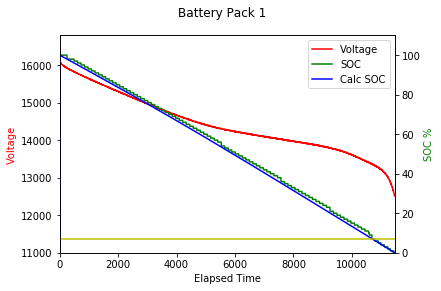

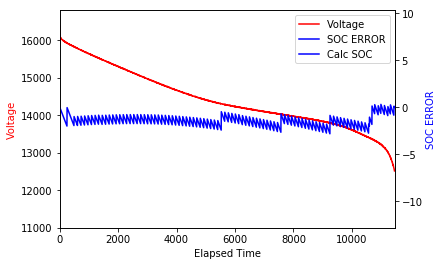

In [7]:
fig = plt.figure()
fig.suptitle('Battery Pack 1')
plot1 = fig.add_subplot(111)

x = battery.elapsed_time
y = battery.Voltage1
z = battery.StateofCharge1
w = calc_SOC1

par1 = plot1.twinx()

plot1.set_xlim(0, battery.elapsed_time[len(battery.elapsed_time)-1])
plot1.set_ylim(11000, 16800)
par1.set_ylim(0, 110)

plot1.set_xlabel("Elapsed Time")
plot1.set_ylabel("Voltage")
par1.set_ylabel("SOC %")

p1, = plot1.plot(x,y, color='r',label="Voltage")
p2, = par1.plot(x,z, color='g', label="SOC")
p3, = par1.plot(x,w, color='b', label="Calc SOC")

par1.axhline(y=7, xmin=0.0, xmax=1.0, color='y')

lns = [p1, p2, p3]
plot1.legend(handles=lns, loc='best')

plot1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.draw()
# plt.show()
plt.savefig(DATA_PATH + '/BatteryPack1_VoltagevsSOC.png')
##################################

fig = plt.figure()
plot1 = fig.add_subplot(111)

x = battery.elapsed_time
y = battery.Voltage1
z = SOC_Error1

par1 = plot1.twinx()

plot1.set_xlim(0, battery.elapsed_time[len(battery.elapsed_time)-1])
plot1.set_ylim(11000, 16800)
par1.set_ylim(min(SOC_Error1)-10, max(SOC_Error1)+10)

plot1.set_xlabel("Elapsed Time")
plot1.set_ylabel("Voltage")
par1.set_ylabel("SOC ERROR")

p1, = plot1.plot(x,y, color='r',label="Voltage")
p2, = par1.plot(x,z, color='b', label="SOC ERROR")

lns = [p1, p2, p3]
plot1.legend(handles=lns, loc='best')
plot1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.draw()
# plt.show()

plt.savefig(DATA_PATH + '/BatteryPack1_VoltageVsSOCError.png')

In [8]:
fig = plt.figure()
fig.suptitle('Battery Pack 2')
plot1 = fig.add_subplot(111)

x = battery.elapsed_time
y = battery.Voltage2
z = battery.StateofCharge2
w = calc_SOC2

par1 = plot1.twinx()

plot1.set_xlim(0, battery.elapsed_time[len(battery.elapsed_time)-1])
plot1.set_ylim(11000, 16800)
par1.set_ylim(0, 110)

plot1.set_xlabel("Elapsed Time")
plot1.set_ylabel("Voltage")
par1.set_ylabel("SOC %")

p1, = plot1.plot(x,y, color='r',label="Voltage")
p2, = par1.plot(x,z, color='g', label="SOC")
p3, = par1.plot(x,w, color='b', label="Calc SOC")

par1.axhline(y=7, xmin=0.0, xmax=1.0, color='y')

lns = [p1, p2, p3]
plot1.legend(handles=lns, loc='best')

plot1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.draw()
# plt.show()
plt.savefig(DATA_PATH + '/BatteryPack2_VoltagevsSOC.png')

##################################

fig = plt.figure()
plot1 = fig.add_subplot(111)

x = battery.elapsed_time
y = battery.Voltage2
z = SOC_Error2

par1 = plot1.twinx()

plot1.set_xlim(0, battery.elapsed_time[len(battery.elapsed_time)-1])
plot1.set_ylim(11000, 16800)
par1.set_ylim(min(SOC_Error2)-10, max(SOC_Error2)+10)

plot1.set_xlabel("Elapsed Time")
plot1.set_ylabel("Voltage")
par1.set_ylabel("SOC ERROR")

p1, = plot1.plot(x,y, color='r',label="Voltage")
p2, = par1.plot(x,z, color='b', label="SOC ERROR")

lns = [p1, p2, p3]
plot1.legend(handles=lns, loc='best')

plot1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.draw()
# plt.show()

plt.savefig(DATA_PATH + '/BatteryPack2_VoltageVsSOCError.png')

In [9]:
print("Battery 1 True Full-Charge Capacity:" + str(max(calc_dQ1)))
print("Battery 2 True Full-Charge Capacity:" + str(max(calc_dQ2)))

Battery 1 True Full-Charge Capacity:[ 2350.90509236]
Battery 2 True Full-Charge Capacity:[ 2341.924978]


In [10]:
EDV_SOC = [0,3,7]
EDV_VAL = []

print("Calculated EDV Points\nBattery1:")
for i in range(len(EDV_SOC)):
    index = abs(calc_SOC1[1:len(calc_SOC1)]-EDV_SOC[i]).argmin()
    voltages = [battery.Cell1Voltage1[index],battery.Cell2Voltage1[index],battery.Cell3Voltage1[index],battery.Cell4Voltage1[index]]
    print("Index:" + str(index) + " Value:" + str(calc_SOC1[index]) + " Voltages(mV):" + str(voltages) + " Voltage Avg:" + str(np.mean(voltages)) + "  | Voltage Min(EDV"+ str(i) + "):" + str(min(voltages)))

print("\nBattery2:")
for i in range(len(EDV_SOC)):
    index = abs(calc_SOC2[1:len(calc_SOC1)]-EDV_SOC[i]).argmin()
    voltages = [battery.Cell1Voltage2[index],battery.Cell2Voltage2[index],battery.Cell3Voltage2[index],battery.Cell4Voltage2[index]]
    print("Index:" + str(index) + " Value:" + str(calc_SOC1[index]) + " Voltages(mV):" + str(voltages) + " Voltage Avg:" + str(np.mean(voltages)) + "  | Voltage Min(EDV"+ str(i) + "):" + str(min(voltages)))


Calculated EDV Points
Battery1:
Index:2483 Value:[ 0.0442507] Voltages(mV):[3015, 3262, 3202, 3076] Voltage Avg:3138.75  | Voltage Min(EDV0):3015
Index:2414 Value:[ 3.02968444] Voltages(mV):[3226, 3329, 3300, 3255] Voltage Avg:3277.5  | Voltage Min(EDV1):3226
Index:2321 Value:[ 7.02387127] Voltages(mV):[3305, 3374, 3353, 3327] Voltage Avg:3339.75  | Voltage Min(EDV2):3305

Battery2:
Index:2483 Value:[ 0.0442507] Voltages(mV):[3042, 3257, 3124, 3139] Voltage Avg:3140.5  | Voltage Min(EDV0):3042
Index:2418 Value:[ 2.85650308] Voltages(mV):[3234, 3329, 3278, 3272] Voltage Avg:3278.25  | Voltage Min(EDV1):3234
Index:2327 Value:[ 6.76637651] Voltages(mV):[3305, 3373, 3341, 3329] Voltage Avg:3337.0  | Voltage Min(EDV2):3305


In [11]:
print('Total Elapsed Time(sec) = ' + str(max(battery.elapsed_time)))
print('Total Elapsed Time(hrs) = ' + str(max(battery.elapsed_time)/3600))

Total Elapsed Time(sec) = 11461.651051
Total Elapsed Time(hrs) = 3.183791958611111
